In [ ]:
from types import SimpleNamespace
import kwant
import numpy as np
import holoviews as hv
hv.notebook_extension()

s0 = np.array([[1., 0.], [0., 1.]])
sx = np.array([[0., 1.], [1., 0.]])
sy = np.array([[0., -1j], [1j, 0.]])
sz = np.array([[1., 0.], [0., -1.]])

onsite = lambda site, p: -p.mu * sz
onsite_lead = lambda site, p: -p.mu * sz + p.delta * sx
hops = lambda site1, site2, p: -p.t * sz

def make_test_system(W, L):
    lat = kwant.lattice.square()
    syst = kwant.Builder()
    range_w = range(W//2 - W + 1, W//2 + 1)
    range_l = range(L//2 - L + 1, L//2 + 1)
    syst[(lat(x, y) for x in range_l for y in range_w)] = onsite
    syst[lat.neighbors()] = hops

    l_cut = [lat(0, y) for y in range_w]
    r_cut = [lat(1, y) for y in range_w]

    num_orbs = 2
    dim = num_orbs * len(l_cut) * len(r_cut)
    vlead = kwant.builder.SelfEnergyLead(lambda energy, args: np.zeros((dim, dim)), r_cut + l_cut)
    syst.leads.append(vlead)
    
    lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))
    lead[(lat(0, y) for y in range_w)] = onsite_lead
    lead[lat.neighbors()] = hops
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    
    r_cut_sites = [syst.sites.index(site) for site in r_cut]
    l_cut_sites = [syst.sites.index(site) for site in l_cut]
    
    def hopping(syst, args=()):
        return syst.hamiltonian_submatrix(args=args,
                                          to_sites=l_cut_sites,
                                          from_sites=r_cut_sites)[::2, ::2]
    return syst, hopping


def matsubara_frequency(T, n):
    return (2*n + 1) * np.pi * T * 1j


def null_H(syst, p, T, n):
    en = matsubara_frequency(T, n)
    gf = kwant.greens_function(syst, en, [p], [0], [0], check_hermiticity=False)
    return np.linalg.inv(gf.data[::2, ::2])


def gf_from_H_0(H_0, t):
    H = np.copy(H_0)
    dim = t.shape[0]
    H[:dim, dim:] -= t.T.conj()
    H[dim:, :dim] -= t
    return np.linalg.inv(H)

# calculation with fixed number of Matsubara frequencies

In [ ]:
# %%timeit
def current_from_H_0(T, H_0s, H12, phase):
    t = H12 * np.exp(1j * phase)
    I = 0
    for H_0 in H_0s:
        gf = gf_from_H_0(H_0, t - H12)
        dim = t.shape[0]
        H12G21 = t.T.conj() @ gf[dim:, :dim]
        H21G12 = t @ gf[:dim, dim:]
        I += -4 * T * (np.trace(H21G12) - np.trace(H12G21)).imag
    return I

W = 2
L = 2
delta = 0.01
T = 0.5 * delta
matsfreqs = 50

syst, hopping = make_test_system(W, L)
p = SimpleNamespace(mu=0., t=1., delta=delta)

H12 = hopping(syst, [p])
phases = np.linspace(-np.pi, np.pi, 51)

H_0s = [null_H(syst, p, T, n) for n in range(matsfreqs)]
I = np.array([current_from_H_0(T, H_0s, H12, phase) for phase in phases])
plt1 = hv.Curve(I/delta/W, kdims=['phase'], vdims=['$I$'])
plt1

# calculation with relative error

b':Curve   [phase]   ($I$)'
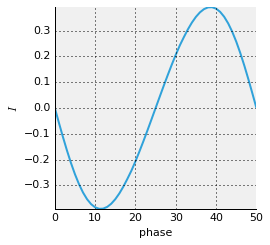

In [34]:
# %%timeit
def current_contrib_from_H_0(T, H_0, H12, phase):
    t = H12 * np.exp(1j * phase) # Maybe take this line outside of the function?
    gf = gf_from_H_0(H_0, t - H12)
    dim = t.shape[0]
    H12G21 = t.T.conj() @ gf[dim:, :dim]
    H21G12 = t @ gf[:dim, dim:]
    return -4 * T * (np.trace(H21G12) - np.trace(H12G21)).imag


def current_at_phase(syst, p, T, H_0s, phase, tol=1e-2):
    H12 = hopping(syst, [p])
    I = current_contrib_from_H_0(T, H_0s[0], H12, phase)
    error = 1
    n = 1
    while error > tol:
        if len(H_0s) <= n:
            print("Calculating H_0 for n = {}".format(n))
            H_0s.append(null_H(syst, p, T, n))
        I_contrib = current_contrib_from_H_0(T, H_0s[n], H12, phase)
        n += 1
        I += I_contrib
        error = np.abs(I_contrib / I)
        if n == 50:
            print('Did not converge in 50 Matsubara frequencies.')
    return I


def current_at_phase(syst, p, T, hamiltonian_cache, phase, tol=1e-2, max_frequencies=50):
    H12 = hopping(syst, [p])
    I = 0
    for n in range(max_frequencies):
        if len(hamiltonian_cache) <= n:
            hamiltonian_cache.append(null_H(syst, p, T, n))
        I_contrib = current_contrib_from_H_0(T, hamiltonian_cache[n], H12, phase)
        I += I_contrib
        if abs(I_contrib / I) < tol:
            return I
    raise RuntimeError('Did not converge using {} Matsubara frequencies.'.format(max_frequencies))


W = 2
L = 2
delta = 0.01
T = 0.5 * delta

syst, hopping = make_test_system(W, L)
p = SimpleNamespace(mu=0., t=1., delta=delta)


phases = np.linspace(-np.pi, np.pi, 51)

H_0s = []
I = np.array([current_at_phase(syst, p, T, H_0s, phase) for phase in phases])
plt2 = hv.Curve(I/delta/W, kdims=['phase'], vdims=['$I$'])
plt2

:Overlay
   .Curve.I  :Curve   [phase]   ($I$)
   .Curve.II :Curve   [phase]   ($I$)
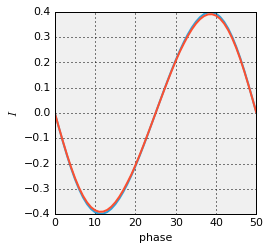

In [35]:
plt1 * plt2